In [7]:
import sys
import notebookutil as nbu
sys.meta_path.append(nbu.NotebookFinder())
import datasets as ds
import pandas as pd
import numpy as np

path = data/raw/01_01_01_4F実験室_XperiaZ3_胸ポケット_裏上_正常_まっすぐ帰宅
data/raw/01_01_01_4F実験室_XperiaZ3_胸ポケット_裏上_正常_まっすぐ帰宅
...
path = data/raw/01_02_01_4F実験室_XperiaZ3_胸ポケット_裏上_異常_まっすぐ外出
data/raw/01_02_01_4F実験室_XperiaZ3_胸ポケット_裏上_異常_まっすぐ外出
...
extracted 3 dataframes
extracted 3 dataframes
[[  0.           8.5003724   10.76833816]
 [  0.           6.75120485   8.5003724 ]
 [  0.           6.75120485  10.76833816]]
[[ 213.03142723  216.08992154  216.11176133]
 [ 175.89596252  178.10115034  178.37824257]
 [ 193.03871568  195.39987538  195.45995085]]


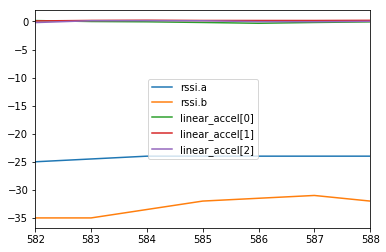

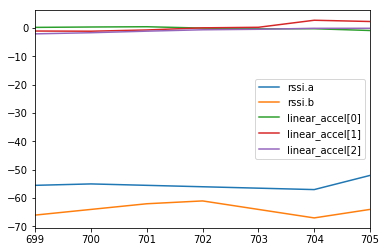

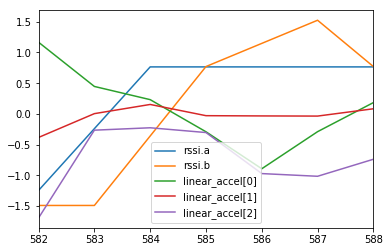

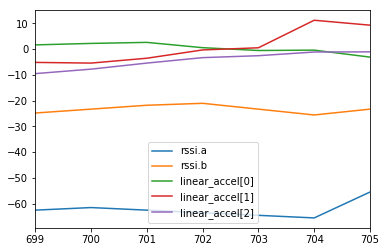

In [8]:
# load dataset
ds_nml = ds.dataset('data/raw/01_01_01_4F実験室_XperiaZ3_胸ポケット_裏上_正常_まっすぐ帰宅')
ds_out = ds.dataset('data/raw/01_02_01_4F実験室_XperiaZ3_胸ポケット_裏上_異常_まっすぐ外出')

# set column
column = ['rssi.a','rssi.b',['linear_accel[0]','linear_accel[1]','linear_accel[2]']]

# get around button pushed time
dfl_nml = ds_nml.get_data(before=6, after=0, column=ds.list_flatten(column))
dfl_out = ds_out.get_data(before=6, after=0, column=ds.list_flatten(column))

# normalize
mean_std = ds.get_mean_std(dfl_nml, column)
dfl_nml_n = ds.normalize(dfl_nml, mean_std)
dfl_out_n = ds.normalize(dfl_out, mean_std)
#dfl_nml_n,ds.normalize(dfl_nml, dfl_out)

# plot graph
dfl_nml[1].plot()
dfl_out[1].plot()
dfl_nml_n[1].plot()
dfl_out_n[1].plot()

# calc k-NN distance
from sklearn.neighbors import NearestNeighbors
X_nml = [d.values.flatten() for d in dfl_nml_n]
X_out = [d.values.flatten() for d in dfl_out_n]
nbrs = NearestNeighbors(n_neighbors=3, algorithm='ball_tree')
nbrs.fit(X_nml)

distances, indices = nbrs.kneighbors(X_nml)
print(distances)
distances, indices = nbrs.kneighbors(X_out)
print(distances)

df_result = pd.DataFrame([[]])